In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [2]:
# load and check dataset
df = pd.read_csv('tract_covariates.csv')
df.head()

,tract,county,state,hhinc_mean2000,mean_commutetime2000,frac_coll_plus2010,frac_coll_plus2000,foreign_share2010,med_hhinc2016,med_hhinc1990,...,mail_return_rate2010,ln_wage_growth_hs_grad,jobs_total_5mi_2015,jobs_highpay_5mi_2015,nonwhite_share2010,popdensity2010,cz,czname,ann_avg_job_growth_2004_2013,job_density_2013
0,20100,1,1,68638.727,26.171911,0.254428,0.156479,0.009950,66000.0,27375.0,...,83.500000,0.038233,10109.0,3396.0,0.162657,504.75183,11101.0,Montgomery,-0.006769,92.133049
1,20200,1,1,57242.512,24.806705,0.267194,0.146932,0.016337,41107.0,19000.0,...,81.300003,0.089306,9948.0,3328.0,0.611060,1682.17050,11101.0,Montgomery,-0.004253,971.317870
2,20300,1,1,75647.727,25.322525,0.164159,0.224413,0.027096,51250.0,29419.0,...,79.500000,-0.177743,10387.0,3230.0,0.247554,1633.41390,11101.0,Montgomery,0.014218,340.920070
3,20400,1,1,74852.055,22.965347,0.252744,0.230469,0.015083,52704.0,37891.0,...,83.500000,-0.072311,12933.0,3635.0,0.081167,1780.03250,11101.0,Montgomery,-0.019841,207.386370
4,20500,1,1,96174.766,26.222353,0.375063,0.321154,0.046488,52463.0,41516.0,...,77.300003,-0.096140,12933.0,3635.0,0.216236,2446.26220,11101.0,Montgomery,0.018627,800.272640


In [3]:
# check number of columns and rows
df.shape

(74123, 38)

In [4]:
# check all columns names
df.columns

Index(['tract', 'county', 'state', 'hhinc_mean2000', 'mean_commutetime2000',
       'frac_coll_plus2010', 'frac_coll_plus2000', 'foreign_share2010',
       'med_hhinc2016', 'med_hhinc1990', 'popdensity2000', 'poor_share2010',
       'poor_share2000', 'poor_share1990', 'share_black2010', 'share_hisp2010',
       'share_asian2010', 'share_black2000', 'share_white2000',
       'share_hisp2000', 'share_asian2000', 'gsmn_math_g3_2013',
       'rent_twobed2015', 'singleparent_share2010', 'singleparent_share1990',
       'singleparent_share2000', 'traveltime15_2010', 'emp2000',
       'mail_return_rate2010', 'ln_wage_growth_hs_grad', 'jobs_total_5mi_2015',
       'jobs_highpay_5mi_2015', 'nonwhite_share2010', 'popdensity2010', 'cz',
       'czname', 'ann_avg_job_growth_2004_2013', 'job_density_2013'],
      dtype='object')

In [5]:
# check percentage of NaNs in each column
df.isna().sum()/len(df)*100

tract                            0.000000
county                           0.000000
state                            0.000000
hhinc_mean2000                   2.333958
mean_commutetime2000             2.301580
frac_coll_plus2010               1.180470
frac_coll_plus2000               2.238172
foreign_share2010                2.354195
med_hhinc2016                    1.577108
med_hhinc1990                    2.297532
popdensity2000                   1.867167
poor_share2010                   1.330221
poor_share2000                   2.302929
poor_share1990                   2.275947
share_black2010                  0.940329
share_hisp2010                   0.940329
share_asian2010                  2.610526
share_black2000                  2.195000
share_white2000                  2.195000
share_hisp2000                   2.195000
share_asian2000                  3.989315
gsmn_math_g3_2013                2.019616
rent_twobed2015                 23.478542
singleparent_share2010           1

In [6]:
# check each column type
df.dtypes

tract                             int64
county                            int64
state                             int64
hhinc_mean2000                  float64
mean_commutetime2000            float64
frac_coll_plus2010              float64
frac_coll_plus2000              float64
foreign_share2010               float64
med_hhinc2016                   float64
med_hhinc1990                   float64
popdensity2000                  float64
poor_share2010                  float64
poor_share2000                  float64
poor_share1990                  float64
share_black2010                 float64
share_hisp2010                  float64
share_asian2010                 float64
share_black2000                 float64
share_white2000                 float64
share_hisp2000                  float64
share_asian2000                 float64
gsmn_math_g3_2013               float64
rent_twobed2015                 float64
singleparent_share2010          float64
singleparent_share1990          float64


In [7]:
# combine tract, map and state as one unique identifier for each census location
df['id'] = df.tract.map(str) + '-' + df.county.map(str) + '-' + df.state.map(str)
df.id.nunique()

74123

In [8]:
# move identifier column to beginning of dataframe 
cols = list(df)
cols.insert(0, cols.pop(cols.index('id')))
df = df.loc[:, cols]

# drop columns that are not necessary or that have a high percentage of NaNs
df.drop(['tract', 'county', 'state', 'cz', 'czname', 'rent_twobed2015', 'ln_wage_growth_hs_grad'], axis=1, inplace=True)
df.head()

,id,hhinc_mean2000,mean_commutetime2000,frac_coll_plus2010,frac_coll_plus2000,foreign_share2010,med_hhinc2016,med_hhinc1990,popdensity2000,poor_share2010,...,singleparent_share2000,traveltime15_2010,emp2000,mail_return_rate2010,jobs_total_5mi_2015,jobs_highpay_5mi_2015,nonwhite_share2010,popdensity2010,ann_avg_job_growth_2004_2013,job_density_2013
0,20100-1-1,68638.727,26.171911,0.254428,0.156479,0.009950,66000.0,27375.0,195.72380,0.105030,...,0.250980,0.273034,0.567308,83.500000,10109.0,3396.0,0.162657,504.75183,-0.006769,92.133049
1,20200-1-1,57242.512,24.806705,0.267194,0.146932,0.016337,41107.0,19000.0,566.38141,0.147590,...,0.392523,0.152040,0.493169,81.300003,9948.0,3328.0,0.611060,1682.17050,-0.004253,971.317870
2,20300-1-1,75647.727,25.322525,0.164159,0.224413,0.027096,51250.0,29419.0,624.19684,0.080385,...,0.244856,0.205534,0.578560,79.500000,10387.0,3230.0,0.247554,1633.41390,0.014218,340.920070
3,20400-1-1,74852.055,22.965347,0.252744,0.230469,0.015083,52704.0,37891.0,713.80396,0.063223,...,0.190722,0.350673,0.596501,83.500000,12933.0,3635.0,0.081167,1780.03250,-0.019841,207.386370
4,20500-1-1,96174.766,26.222353,0.375063,0.321154,0.046488,52463.0,41516.0,529.93030,0.059569,...,0.168000,0.250496,0.661268,77.300003,12933.0,3635.0,0.216236,2446.26220,0.018627,800.272640


In [9]:
# check overal stats of dataframe
df.describe()

,hhinc_mean2000,mean_commutetime2000,frac_coll_plus2010,frac_coll_plus2000,foreign_share2010,med_hhinc2016,med_hhinc1990,popdensity2000,poor_share2010,poor_share2000,...,singleparent_share2000,traveltime15_2010,emp2000,mail_return_rate2010,jobs_total_5mi_2015,jobs_highpay_5mi_2015,nonwhite_share2010,popdensity2010,ann_avg_job_growth_2004_2013,job_density_2013
count,72393.000000,72417.000000,73248.000000,72464.000000,72378.000000,72954.000000,72420.000000,72739.000000,73137.000000,72416.000000,...,72378.000000,73160.000000,72467.000000,72789.000000,7.268000e+04,7.268000e+04,73426.000000,73642.000000,70664.000000,7.246300e+04
mean,80327.556155,26.946929,0.269188,0.237791,0.120875,58810.315528,32178.195869,1983.551558,0.151696,0.128522,...,0.293477,0.295065,0.594060,78.692768,1.119495e+05,5.855423e+04,0.368949,5236.287765,0.015335,2.157003e+03
std,34437.757785,7.015295,0.182729,0.168770,0.137757,29670.457993,14327.205251,4544.191364,0.128338,0.110132,...,0.157817,0.155631,0.112812,7.876387,2.517040e+05,1.553782e+05,0.307444,11701.388496,0.076179,1.876617e+04
min,7239.477100,2.500000,0.000000,0.000000,0.000000,2499.000000,4999.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,-0.606690,0.000000e+00
25%,57366.266000,22.034706,0.130765,0.110645,0.023023,38698.000000,22257.000000,95.557041,0.059191,0.050159,...,0.182487,0.184125,0.532866,74.300003,6.454000e+03,2.279750e+03,0.108159,314.829350,-0.018859,5.673720e+01
50%,71705.953000,26.164030,0.218334,0.186889,0.067070,52291.500000,29806.500000,755.014890,0.116065,0.095659,...,0.258736,0.265494,0.607797,79.599998,4.221550e+04,1.691450e+04,0.265904,2189.878900,0.008496,4.125840e+02
75%,94675.211000,31.048534,0.370618,0.325419,0.168883,71851.000000,39408.250000,2000.978350,0.205636,0.171529,...,0.366292,0.376318,0.670782,84.300003,1.228150e+05,5.771550e+04,0.587899,5284.204800,0.040975,1.371066e+03
max,434368.630000,80.025421,1.000000,1.000000,1.000000,250001.000000,150001.000000,205382.190000,1.000000,1.000000,...,1.000000,1.000000,1.000000,100.000000,2.826437e+06,1.794186e+06,1.000000,543333.310000,1.336456,2.905290e+06


A few things we can notice here: 

- some columns present the same data from different years. It could make more sense to treat these as one column for change, instead of keeping both years data.

- data magnitude varies a lot from column to column and scaling and standardizing will certainly be necessary.

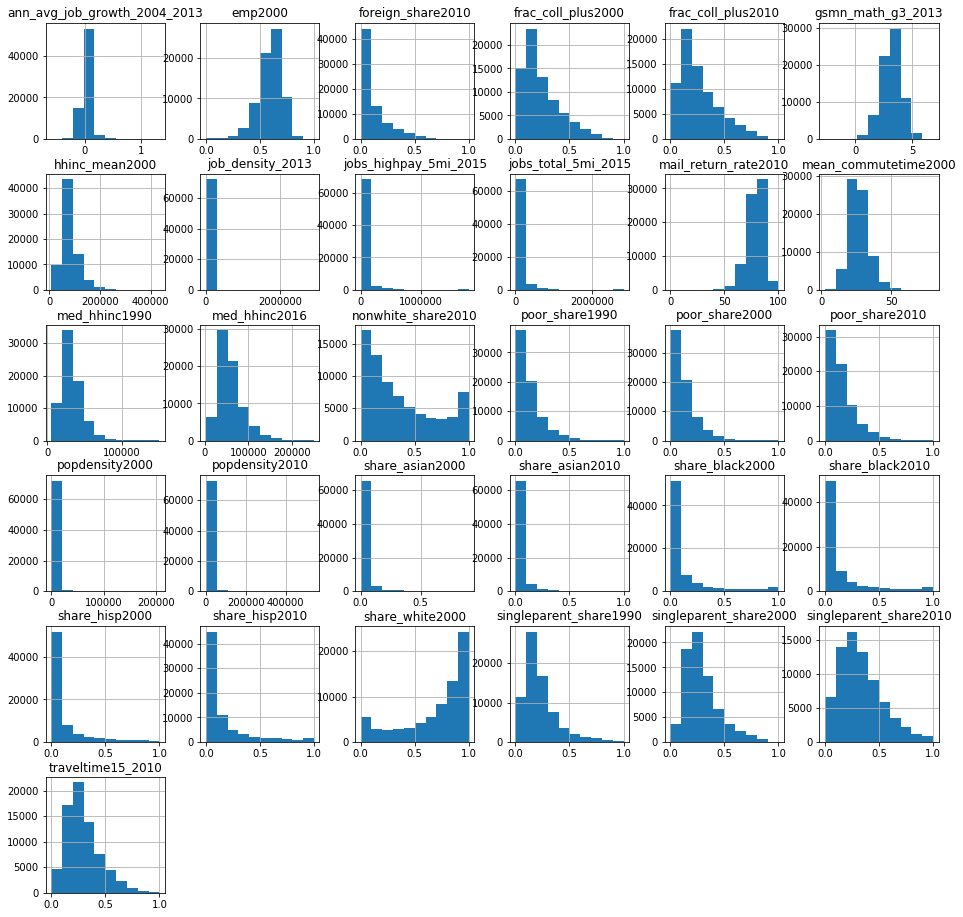

In [10]:
df.hist(figsize=(16,16));

Now let's get our target variable. We want to measure social mobility - meaning, when children fair better in terms of income than their parents. To do this, we will bring data from another dataset, in the same study, that has ranks for income for both parents and children.

kfr_pooled_pooled_mean = Mean percentile rank (relative to other children born in the same year) in the national distribution of household income (i.e. own earnings and spouse’s earnings) measured as mean earnings in 2014-2015 for the baseline sample

par_rank_pooled_pooled_mean = Mean household income rank for parents of children of race [race] and gender [gender]. Parents are ranked relative to other parents with children in the same birth cohort (averaged over 1994-1995 and 1998-2000)

In [11]:
# load necessary information from dataframe
df3 = pd.read_csv('tract_outcomes_early.csv', usecols=['tract', 'county', 'state', 'kfr_pooled_pooled_mean', 'par_rank_pooled_pooled_mean'])

In [12]:
# check dataframe
df3.head()

,state,county,tract,kfr_pooled_pooled_mean,par_rank_pooled_pooled_mean
0,1,1,20100,0.481355,0.512273
1,1,1,20200,0.370569,0.357840
2,1,1,20300,0.487227,0.534671
3,1,1,20400,0.536163,0.597961
4,1,1,20500,0.579610,0.651672


In [13]:
# combine tract, map and state as one unique identifier for each census location
df3['id'] = df3.tract.map(str) + '-' + df3.county.map(str) + '-' + df3.state.map(str)

In [14]:
# move identifier column to beginning of dataframe 
cols = list(df3)
cols.insert(0, cols.pop(cols.index('id')))
df3 = df3.loc[:, cols]

In [15]:
# remove columns that are no longer needed
df3.drop(['tract', 'county', 'state'], axis=1, inplace=True)

In [16]:
# check number of columns and rows
df3.shape

(73278, 3)

In [17]:
# check percentage of NaNs
df3.isna().sum()/len(df3)*100

id                             0.000000
kfr_pooled_pooled_mean         1.724938
par_rank_pooled_pooled_mean    1.724938
dtype: float64

In [18]:
# calculate mobility in a new column by subtracting rank from parents' rank
df3['mobility'] = df3['kfr_pooled_pooled_mean'] - df3['par_rank_pooled_pooled_mean']

In [19]:
# check stats
df3.describe()

,kfr_pooled_pooled_mean,par_rank_pooled_pooled_mean,mobility
count,72014.000000,72014.000000,72014.000000
mean,0.507519,0.523503,-0.015984
std,0.095564,0.153076,0.081375
min,0.158528,0.101707,-0.688561
25%,0.443233,0.413284,-0.072159
50%,0.512092,0.519227,-0.016234
75%,0.576070,0.633467,0.037503
max,0.792643,0.957305,0.419661


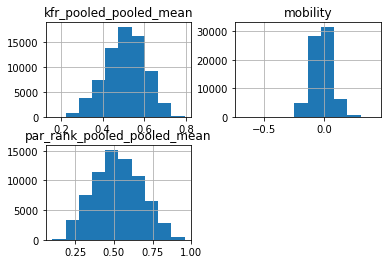

In [20]:
# check distribution
df3.hist();

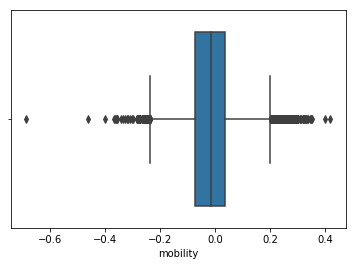

In [21]:
# check outliers
sns.boxplot(df3.mobility)

In [22]:
# check percentage at positive mobility
len(df3.mobility[df3.mobility > 0])/len(df3.mobility)*100

41.312535822484236

In [23]:
# classify outcomes for positive mobility and no/negative mobility
df3['outcome'] = np.where(df3.mobility > 0, 1, 0)

In [24]:
# check balance of target variable
df3.outcome.value_counts()/len(df3)

0    0.586875
1    0.413125
Name: outcome, dtype: float64

In [25]:
# drop all the other columns, keeping only the outcome
df3.drop(columns=['kfr_pooled_pooled_mean', 'par_rank_pooled_pooled_mean', 'mobility'], inplace=True)

In [26]:
# merge dataframes
df = pd.merge(df, df3, on='id')
df.head()

,id,hhinc_mean2000,mean_commutetime2000,frac_coll_plus2010,frac_coll_plus2000,foreign_share2010,med_hhinc2016,med_hhinc1990,popdensity2000,poor_share2010,...,traveltime15_2010,emp2000,mail_return_rate2010,jobs_total_5mi_2015,jobs_highpay_5mi_2015,nonwhite_share2010,popdensity2010,ann_avg_job_growth_2004_2013,job_density_2013,outcome
0,20100-1-1,68638.727,26.171911,0.254428,0.156479,0.009950,66000.0,27375.0,195.72380,0.105030,...,0.273034,0.567308,83.500000,10109.0,3396.0,0.162657,504.75183,-0.006769,92.133049,0
1,20200-1-1,57242.512,24.806705,0.267194,0.146932,0.016337,41107.0,19000.0,566.38141,0.147590,...,0.152040,0.493169,81.300003,9948.0,3328.0,0.611060,1682.17050,-0.004253,971.317870,1
2,20300-1-1,75647.727,25.322525,0.164159,0.224413,0.027096,51250.0,29419.0,624.19684,0.080385,...,0.205534,0.578560,79.500000,10387.0,3230.0,0.247554,1633.41390,0.014218,340.920070,0
3,20400-1-1,74852.055,22.965347,0.252744,0.230469,0.015083,52704.0,37891.0,713.80396,0.063223,...,0.350673,0.596501,83.500000,12933.0,3635.0,0.081167,1780.03250,-0.019841,207.386370,0
4,20500-1-1,96174.766,26.222353,0.375063,0.321154,0.046488,52463.0,41516.0,529.93030,0.059569,...,0.250496,0.661268,77.300003,12933.0,3635.0,0.216236,2446.26220,0.018627,800.272640,0


In [27]:
# check percentage of NaNs
df.isna().sum()/len(df)*100

id                              0.000000
hhinc_mean2000                  1.331914
mean_commutetime2000            1.316903
frac_coll_plus2010              0.388930
frac_coll_plus2000              1.275963
foreign_share2010               1.363301
med_hhinc2016                   0.702803
med_hhinc1990                   1.316903
popdensity2000                  1.104015
poor_share2010                  0.470810
poor_share2000                  1.314173
poor_share1990                  1.303256
share_black2010                 0.227899
share_hisp2010                  0.227899
share_asian2010                 1.819100
share_black2000                 1.241846
share_white2000                 1.241846
share_hisp2000                  1.241846
share_asian2000                 3.040476
gsmn_math_g3_2013               1.621223
singleparent_share2010          0.974372
singleparent_share1990          1.476569
singleparent_share2000          1.355113
traveltime15_2010               0.462622
emp2000         

In [28]:
# drop rows with NaNs
df = df.dropna()

In [29]:
# check lenght of rows and columns
df.shape

(67395, 33)

In [30]:
# check balance of target after drop of NaNs
df.outcome.value_counts()/len(df.outcome)*100

0    59.008829
1    40.991171
Name: outcome, dtype: float64

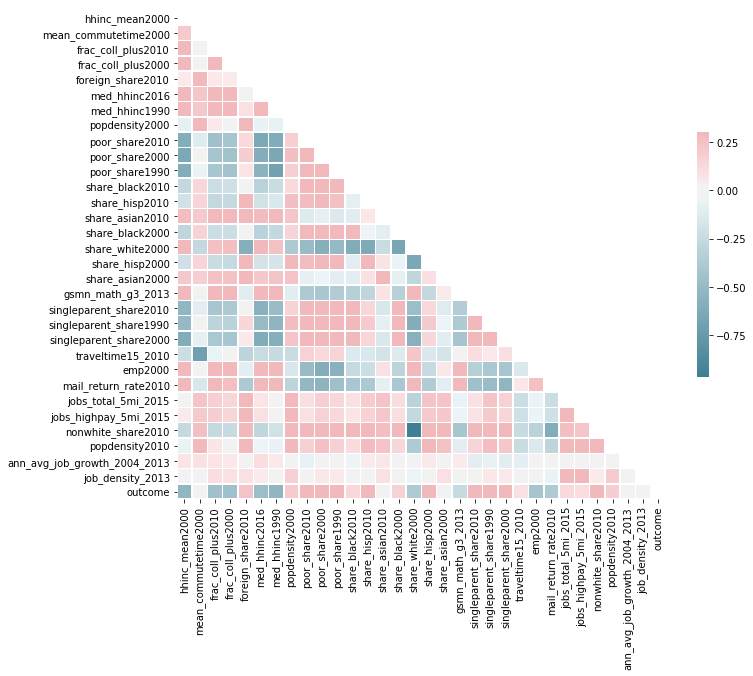

In [31]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [32]:
# define target variable
target = df.outcome

In [33]:
# define features
features = df.iloc[:,1:32]

In [34]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.4, random_state=42)

In [35]:
# Instantiate and fit a RandomForestClassifier - base model
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [36]:
# check training accuracy score
forest.score(X_train, y_train)

0.8525113138956896

In [37]:
# check test accuracy score
forest.score(X_test, y_test)

0.8469471029008087

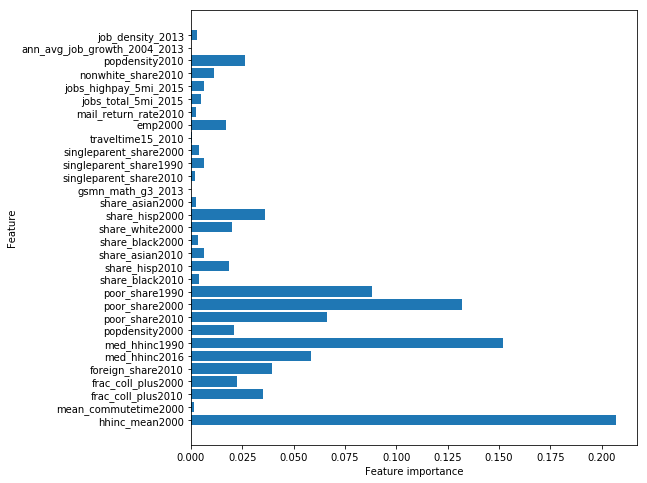

In [38]:
# plot and check feature importance
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(forest)

In [39]:
# X = pd.concat([X_train,y_train],axis=1)

# no_mobility = X[X.outcome==0]
# mobility = X[X.outcome==1]

# # upsample minority
# mobility_upsampled = resample(mobility,
#                           replace=True, # sample with replacement
#                           n_samples=len(no_mobility), # match number in majority class
#                           random_state=27) # reproducible results

# # combine majority and upsampled minority
# upsampled = pd.concat([no_mobility, mobility_upsampled])

# # check new class counts
# upsampled.outcome.value_counts()

In [40]:
# X_train = upsampled.iloc[:,1:32]
# y_train = upsampled.outcome

In [41]:
# # Instantiate and fit another RandomForestClassifier
# forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
# forest.fit(X_train, y_train)

In [42]:
# # Training accuracy score
# forest.score(X_train, y_train)

In [43]:
# # Test accuracy score
# forest.score(X_test, y_test)

In [44]:
# create a pipeline 
pipe = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=30)),
                 ('clf', RandomForestClassifier(n_estimators=100, max_depth= 5, random_state=42))])

In [45]:
# fit model
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           ...tors=100, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False))])

In [54]:
# train score
pipe.score(X_train, y_train)

0.835769221257759

In [46]:
# test score
print('Pipeline test accuracy: %.3f' % (pipe.score(X_test, y_test)))

Pipeline test accuracy: 0.829


In [47]:
# use a pipeline with grid search
pipe_rf = Pipeline([('scaler', StandardScaler()),
                     ('pca', PCA(n_components=30)),
                    ('clf', RandomForestClassifier(random_state=42))])

# Set grid search params
param_grid_forest = [ 
  {'clf__n_estimators': [120],
   'clf__criterion': ['entropy', 'gini'], 
   'clf__max_depth': [4, 5, 6],  
   'clf__min_samples_leaf':[0.05 ,0.1, 0.2],  
   'clf__min_samples_split':[0.05 ,0.1, 0.2]
  }
]

# Construct grid search
gs_rf = GridSearchCV(estimator=pipe_rf,
            param_grid=param_grid_forest,
            scoring='accuracy',
            cv=3, return_train_score = True)

# Fit using grid search
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
           ...s='warn', n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'clf__n_estimators': [120], 'clf__criterion': ['entropy', 'gini'], 'clf__max_depth': [4, 5, 6], 'clf__min_samples_leaf': [0.05, 0.1, 0.2], 'clf__min_samples_split': [0.05, 0.1, 0.2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [48]:
# Best accuracy
print('Best accuracy: %.3f' % gs_rf.best_score_)

# Best params
print('\nBest params:\n', gs_rf.best_params_)

Best accuracy: 0.817

Best params:
 {'clf__criterion': 'gini', 'clf__max_depth': 6, 'clf__min_samples_leaf': 0.05, 'clf__min_samples_split': 0.05, 'clf__n_estimators': 120}


In [49]:
gs_rf.score(X_test, y_test)

0.8159729950293049

Try another type of model instead of Random Forest. Let's see how a Support Vector Machine does.

In [51]:
# SVM model
pipe2 = Pipeline([('scaler', StandardScaler()),
                 ('pca', PCA(n_components=30)),
                 ('SVM', SVC())])

In [52]:
# fit the model
pipe2.fit(X_train, y_train)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('SVM', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [55]:
# train score
pipe2.score(X_train, y_train)

0.8749907263150085

In [56]:
# test score
pipe2.score(X_test, y_test)

0.8663476519029601

In [59]:
# decision tree model
pipe3 = Pipeline([('scaler', StandardScaler()),
                  ('pca', PCA(n_components=30)),
        ('clf', tree.DecisionTreeClassifier(random_state=42))])

In [60]:
# fit the model
pipe3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
           ...        min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])

In [61]:
# train score
pipe3.score(X_train, y_train)

1.0

In [62]:
# test score
pipe3.score(X_test, y_test)

0.7866310557162994

for future work: evaluate by race and gender to see if they are good predictors or even better predictors than other variables